# Quantum Counting
The following document shall describe the Quantum Counting Algorithm. The Quantum Counting Algorithm leverages the Quantum Fourier Transform as well as the Grover operator to count the number of positive solutions to a decision pproblem. The positive solutions may thereafter be determined via Grover's Algorithm. We first import the necessary qiskit libraries and define the relevant circuit parameters.

In [1]:
import numpy as np
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import ZGate, XGate

In [2]:
# Define circuit parameters
a = '10x01xx'
n = len(a)
k = 7

## Objective
We are given an oracle function $f(x)$ thats acts on $n$ bit inputs and produces a $0$ or a $1$ as output. The oracle function $f(x)$ is associated with a set of $m$ specific $n$ bit numbers $\{a_1, a_2, \dots a_m\}$. $f(x)$ tells us whether a given input $a$ belongs to this set or not. Thus,

$$f(x) = \begin{cases}
&1\;; \quad x \in \{a_1, a_2, \dots a_m\} \\
&0\;; \quad x \not\in \{a_1, a_2, \dots a_m\} \end{cases}$$

Our objective is to determine the number of elements in the set $\{a_1, a_2, \dots a_m\}$, i.e., the number of elements in $\{x:f(x) = 1\}$.

## Prerequisites
Before describing the Quantum Counting Algorithm, we shall need to develop a couple of theorems that we will have the need to invoke, while describing the circuit operation. This is done in the following. We also define the Grover Operators $V$ and $W$ in the context of the second of these theorems. The Grover operator $G$ is defined in theorem 3. We do not directly use the second theorem while describing the circuit operation but it is necessary for the proof of the third theorem, which we shall have the need to invoke. It is also advisable to read the corresponding articles on Quantum Phase Estimation and Grover's Algorithm. 

### Theorem 1
This theorem describes the action of a series of Hadamard Transforms on a series of qubits initialized to $|0\rangle_n$. We claim that

$$H^{\otimes n}|0\rangle_n = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

where
1. $H^{\otimes n}$ is the $H$ operator applied individually to each of the $n$ qubits.
2. $|x\rangle_n$ is a shorthand for the $n$ bit binary representation of $x$. For example, $|3\rangle_4 = |0011\rangle$

#### Proof
$$\begin{align*}
H^{\otimes n}|0\rangle_n &= H|0\rangle \otimes H|0\rangle \otimes \cdots \otimes H|0\rangle \\
&= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \cdots \otimes \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}}\left(\left(|0\rangle + |1\rangle\right) \otimes \left(|0\rangle + |1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + |1\rangle\right) \right)
\end{align*}$$

Now, multiplying out the $\left(|0\rangle + |1\rangle\right)$ terms, we get a sum of all possible combinations of zeroes and ones. Thus, we get our final result,

$$H^{\otimes n}|0\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

### Theorem 2
Define the states $|\phi\rangle$ and $|\psi\rangle$ as

$$|\phi\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \qquad |\psi\rangle = \frac{1}{\sqrt{m}} \sum_{i = 1}^m |a_i\rangle_n$$

Define the Grover Operators $V$ and $W$ as

$$V = I - 2|\psi\rangle\langle\psi| \qquad W = 2|\phi\rangle\langle\phi| - I$$

Let $|\chi\rangle$ be any state in the plane of $|\phi\rangle$ and $|\psi\rangle$, i.e., in the 2D subspace spanned by $|\phi\rangle$ and $|\psi\rangle$. Let $|\psi_\perp\rangle$ be the vector orthogonal to $|\psi\rangle$ in the same plane and let $\theta$ be the angle between $|\phi\rangle$ and $|\psi_\perp\rangle$, i.e., $\theta = cos^{-1} \left(|\langle\psi_\perp|\phi\rangle|\right)$.

Then, we claim that the action of the operator $VW$ rotates the state $|\chi\rangle$ by $2\theta$ towards $|\psi\rangle$.

#### Proof
The above claim is easily visualized geometrically. First, let $S = span\{|\phi\rangle, |\psi\rangle\}$. Note that $\langle\phi|\psi\rangle = \langle\psi|\phi\rangle = \sqrt{\frac{m}{2^n}}$. We observe that

$$\begin{align}
V|\phi\rangle = |\phi\rangle - 2\sqrt{\frac{m}{2^n}}|\psi\rangle \qquad &V|\psi\rangle = -|\psi\rangle \\
W|\phi\rangle = |\phi\rangle \qquad &W|\psi\rangle = 2\sqrt{\frac{m}{2^n}}|\phi\rangle - |\psi\rangle \\
\end{align}$$

Thus, $|\chi\rangle \in S \implies VW|\chi\rangle \in S$. Notice that $V$ preserves the component of $|\chi\rangle$ along $|\psi_\perp\rangle$ while it negates the component of $|\chi\rangle$ along $|\psi\rangle$. Thus, $V$ is a reflection about $|\psi_\perp\rangle$. Similarly, $W$ can be seen as a reflection about $|\phi\rangle$. Two relections make a rotation on the plane. Thus, $VW$ is a rotation.

Let $|\chi\rangle$ make an angle $\gamma$ with $|\psi_\perp\rangle$. We know $|\phi\rangle$ makes an angle $\theta$ with $|\psi_\perp\rangle$. Since $V$ is a reflection about $|\psi_\perp\rangle$, therefore $V|\chi\rangle$ makes an angle $-\gamma$ with $|\psi_\perp\rangle$ and hence an angle $-\theta - \gamma$ with $|\phi\rangle$. Reflecting about $|\phi\rangle$, $WV|\chi\rangle$ makes an angle $\theta + \gamma$ with $|\phi\rangle$ and hence an angle $\gamma + 2\theta$ with $|\psi_\perp\rangle$. Thus, $VW$ is a rotation of $2\theta$ toward $|\psi\rangle$.

### Theorem 3
Define the Grover operator $G = VW$, where $V$ and $W$ are as given above. Then, $G$ can be restricted to the plane of $|\phi\rangle$ and $|\psi\rangle$ (as defined above) and in this subspace, it has the following eigenvalues:

$$a = e^{i2\theta} \qquad b = e^{-i2\theta}$$

with the corresponding eigenvectors being

$$|a\rangle = |\psi\rangle + i|\psi_\perp\rangle \qquad |b\rangle = |\psi\rangle - i|\psi_\perp\rangle$$

Therefore, in the plane of $|\phi\rangle$ and $|\psi\rangle$, $G$ is given by

$$G = e^{i2\theta}|a\rangle\langle a| + e^{-i2\theta}|b\rangle\langle b|$$

#### Proof
$G$ can be restricted to the plane of $|\phi\rangle$ and $|\psi\rangle$ because from theorem 2 above, $G$ is a rotation in this plane and is thus closed within this plane. In this plane, from theorem 2, $G$ has the following matrix representation with respect to the $\{|\psi_\perp\rangle, |\psi\rangle\}$ basis.

$$G \equiv \begin{bmatrix}
cos(2\theta) & -sin(2\theta)\\
sin(2\theta) & cos(2\theta)
\end{bmatrix}$$

The eigenvalues and eigenvectors are then easily verified to be as above.

#### Corollary
The state $|\phi\rangle$ is in the same plane as $|\psi\rangle$ and $|\psi_\perp\rangle$ and is hence a linear combination of the two, and from the above theorem, is therefore a linear combination of $|a\rangle$ and $|b\rangle$. Thus,

$$|\phi\rangle = \alpha|a\rangle + \beta|b\rangle$$

## Circuit Description & Analysis
Next, we describe the circuit for the Quantum Counting Algorithm. It is essentially the phase estimation circuit applied for the Grover operator.

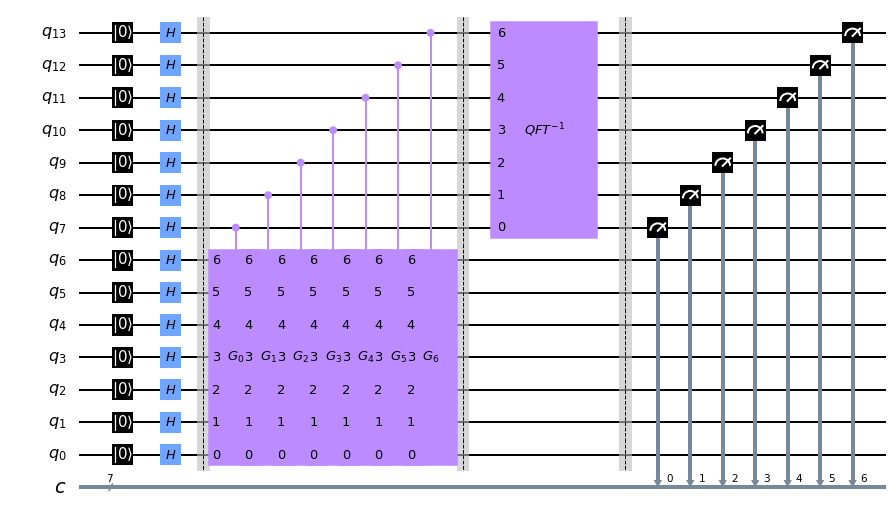

In [3]:
circ = QuantumCircuit(k+n, k)
circ.reset(range(k+n))
circ.h(range(k+n))
circ.barrier()
for i in range(k):
    name = '$G_' + str(i) + '$'
    circ.append(QuantumCircuit(n, name=name).to_gate().control(1), [n+i]+list(range(n)))
circ.barrier()
circ.append(Gate(name="$QFT^{-1}$", num_qubits=k, params=[]), range(n, k+n))
circ.barrier()
circ.measure(range(n, k+n), range(k))
circ.draw('mpl', reverse_bits=True, scale=0.5)

Here, the $n$ qubit unitary operators $G_j$ are given by

$$G_j = G^{2^j}$$

where $G$ is the Grover operator defined in theorem 3 above. QFT refers to the $k$ qubit quantum fourier transform. Its operation is described as

$$QFT|x\rangle = \frac{1}{2^{n/2}} \sum_{y=0}^{2^k-1} e^{2 \pi i \frac{xy}{2^k}}|y\rangle$$

In the above circuit, we have marked out 3 barriers. We shall describe the circuit operation by evaluating the quantum state of the qubits at these barriers, which we shall number 1-3 from left to right.

### Barrier 1
We initialize all qubits to zeros. We apply an $H$ transform to an $n$ bit register as well as a $k$ bit register. By theorem 1 above, the state of the qubits is

$$\begin{align*}
|\psi_1\rangle &= H^{\otimes k}|0\rangle_k \otimes H^{\otimes n}|0\rangle_n \\
&= \frac{1}{2^{(k+n)/2}} \sum_{x = 0}^{2^{k}-1} \sum_{y = 0}^{2^{n}-1} |x\rangle_k \otimes |y\rangle_n \\
&= \frac{1}{2^{k/2}} \sum_{x = 0}^{2^{k}-1} |x\rangle_k \otimes |\phi\rangle_n \\
&= \frac{1}{2^{k/2}} \sum_{x = 0}^{2^{k}-1} |x\rangle_k \otimes \left(\alpha|a\rangle_n + \beta|b\rangle_n\right)
\end{align*}$$

where $|\phi\rangle$ is as defined in theorem 2, and in the last step we have used the corollary to theorem 3 above.

### Barrier 2
We apply a series of controlled $G_j$ gates to the $n$ qubit register, with the control qubit being the $j^{th}$ qubit $x_j$ of the $k$ qubit register. We thus get,

$$\begin{align*}
|\psi_2\rangle &= \frac{1}{2^{k/2}} \sum_{x = 0}^{2^{k}-1} |x\rangle_k \otimes G_0^{x_0}G_1^{x_1} \dots G_{n-1}^{x_{n-1}} \left(\alpha|a\rangle_n + \beta|b\rangle_n\right) \\
&= \frac{1}{2^{k/2}} \sum_{x = 0}^{2^{k}-1} |x\rangle_k \otimes G^{2^0 x_0 + 2^1 x_1 + \dots + 2^{n-1} x_{n-1}} \left(\alpha|a\rangle_n + \beta|b\rangle_n\right) \\
&= \frac{1}{2^{k/2}} \sum_{x = 0}^{2^{k}-1} |x\rangle_k \otimes G^x \left(\alpha|a\rangle_n + \beta|b\rangle_n\right) \\
&= \frac{1}{2^{k/2}} \sum_{x = 0}^{2^{k}-1} \left(\alpha e^{2 i \theta x}|x\rangle_k \otimes |a\rangle_n + \beta e^{-2 i \theta x}|x\rangle_k \otimes |b\rangle_n\right) \\
&= \frac{1}{2^{k/2}} \sum_{x = 0}^{2^{k}-1} \left(\alpha e^{2 i \theta x}|x\rangle_k \otimes |a\rangle_n + \beta e^{2 i (\pi - \theta) x}|x\rangle_k \otimes |b\rangle_n\right) \\
\end{align*}$$

where the result of theorem 3 has been used in the second to last step. The last step is justified because $e^{2\pi i x} = 1$ if $x$ is an integer. If $\frac{2^k \theta}{\pi}$ and $\frac{2^k (\pi - \theta)}{\pi}$ are integers, we can write this as

$$\begin{align*}
|\psi_2\rangle &= \frac{1}{2^{k/2}} \sum_{x = 0}^{2^{k}-1} \left(\alpha e^{2 \pi i \frac{\frac{2^k \theta}{\pi} x}{2^k}}|x\rangle_k \otimes |a\rangle_n + \beta e^{2 \pi i \frac{\frac{2^k (\pi - \theta)}{\pi} x}{2^k}}|x\rangle_k \otimes |b\rangle_n\right) \\
&= \alpha\left(QFT\;\left|\frac{2^k \theta}{\pi}\right\rangle_k\right) \otimes |a\rangle_{n} + \beta\left(QFT\;\left|\frac{2^k (\pi - \theta)}{\pi}\right\rangle_k\right) \otimes |b\rangle_{n} \\
\end{align*}$$


### Barrier 3
We apply an inverse $QFT$ to the $k$ qubit register. If $\frac{2^k \theta}{\pi}$ and $\frac{2^k (\pi - \theta)}{\pi}$ are integers, we get the state as,

$$|\psi_3\rangle = \alpha\;\left|\frac{2^k \theta}{\pi}\right\rangle_k \otimes |a\rangle_{n} + \beta\;\left|\frac{2^k (\pi - \theta)}{\pi}\right\rangle_k\ \otimes |b\rangle_{n}$$

If $\frac{2^k \theta}{\pi}$ and $\frac{2^k (\pi - \theta)}{\pi}$ are not integers, we get a superposition of integer states with states whose values are close to these numbers, having larger probabilities.

### Measurement & Post Processing
We simply measure the $k$ qubit register. If $\frac{2^k \theta}{\pi}$ and $\frac{2^k (\pi - \theta)}{\pi}$ are integers, we get one of their exact values. If they are not integers, we get an integer close to one of them and still get a reasonable estimate. Multiple runs can and should be made in general to ensure that we get the right value.

Now, we note that

$$\theta = cos^{-1} \left(|\langle\psi_\perp|\phi\rangle|\right) = sin^{-1} \left(|\langle\psi|\phi\rangle|\right) = sin^{-1} \sqrt{\frac{m}{2^n}} $$

which is quite small if $2^n$ is large and $m$ is comparatively small. In that case

$$\theta \approx \sqrt{\frac{m}{2^n}} $$

Thus, we require $\theta < \frac{\pi}{2}$. We can use this condition to decide which among the two above values we obtain in a given run. From there, we can estimate $\theta$ since $2^k$ is known and thus, from the above equation, estimate $m$.

## Qiskit Implementation
We shall need to implement the following components before we perform any simulations.

1. The Operators $G_j$
2. The $QFT^{-1}$ Operator

For the oracle circuit we shall choose a circuit which returns $1$ as the output if and only if the input bits match the variable $a$ defined at the beginning of the document exactly, except at the places marked as 'x'. The circuit for this function is easily constructed using a multi-controlled $X$ gate. From this circuit, the $G$ operator and hence the $G_j$ operators are easily constructed (refer to Grover's Algorithm)

For the $QFT^{-1}$ Operator, standard implementations can be found in almost all the standard textbooks on the subject. We do not provide the theoretical details involved in implementation. We directly show the circuit instead, which can be easily verified to produce the desired transformation.

### Grover Operators $G_j$

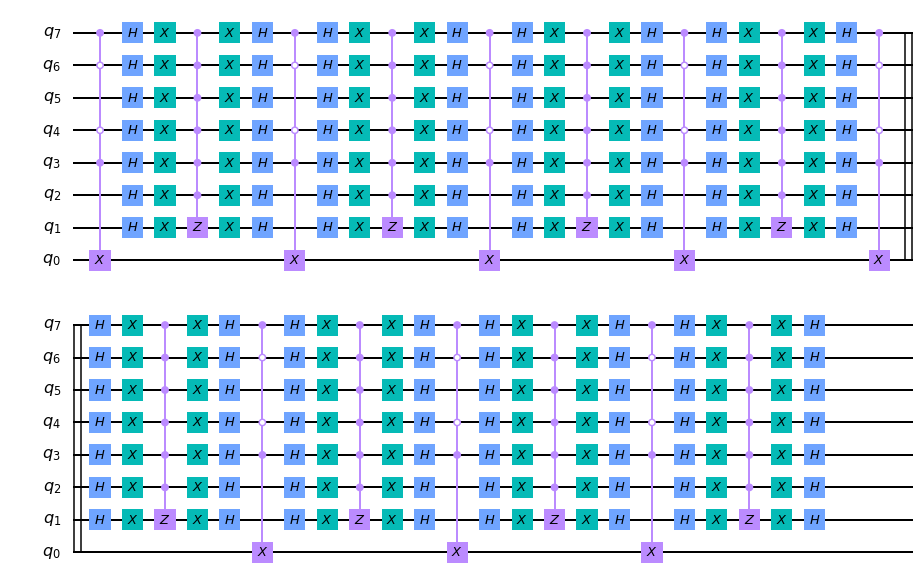

In [4]:
def Gop(j):
    p = 2 ** j
    ctrl_bits = []
    ctrl_state = ''
    for i in range(n):
        if a[n-i-1] != 'x':
            ctrl_bits.append(i+1)
            ctrl_state += a[n-i-1]
    G = QuantumCircuit(n+1, name='G'+str(j))
    for i in range(p):
        G.append(XGate().control(len(ctrl_bits), ctrl_state=ctrl_state[::-1]), ctrl_bits + [0])
        G.h(range(1, n+1))
        G.x(range(1, n+1))
        G.append(ZGate().control(n-1), reversed(range(1, n+1)))
        G.x(range(1, n+1))
        G.h(range(1, n+1))
    return G

Gop(3).draw('mpl', reverse_bits=True, scale=0.5)

### Inverse Quantum Fourier Transform

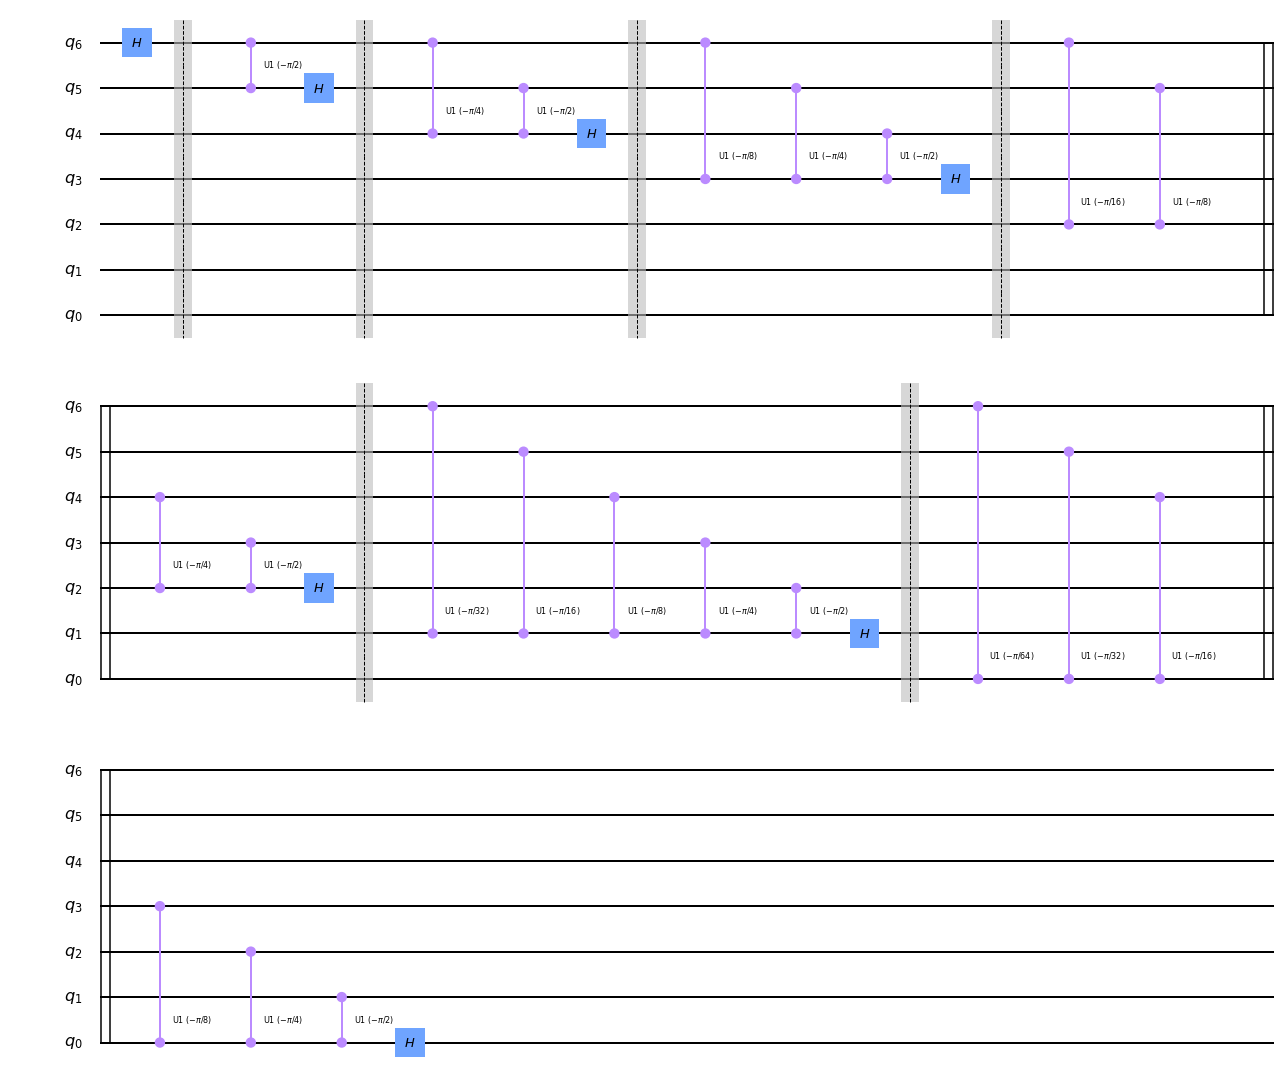

In [5]:
QFT_inv = QuantumCircuit(k, name='QFT^{-1}')
for i in reversed(range(k)):
    if i != k-1:
        QFT_inv.barrier()
    for j in reversed(range(i+1,k)):
        QFT_inv.cu1(-pi/(2 ** (j-i)), i, j)
    QFT_inv.h(i)
QFT_inv.draw('mpl', reverse_bits=True)

## QASM Simulation

In [6]:
circ = QuantumCircuit(k+n+1, k)
circ.reset(range(k+n+1))
circ.x(0)
circ.h(range(k+n+1))
circ.z(n+1)
circ.barrier()
for i in range(k):
    circ.append(Gop(i).to_gate().control(1), [n+i+1]+list(range(n+1)))
circ.barrier()
circ.append(QFT_inv, range(n+1, k+n+1))
circ.barrier()
circ.measure(range(n+1, k+n+1), range(k))
circ.draw(reverse_bits=True, scale=0.5)

┌───┐      ░                                                   ░ »
q_14: ─|0>─┤ H ├──────░──────────────────────────────────────────────■────░─»
           ├───┤      ░                                              │    ░ »
q_13: ─|0>─┤ H ├──────░───────────────────────────────────────■──────┼────░─»
           ├───┤      ░                                       │      │    ░ »
q_12: ─|0>─┤ H ├──────░────────────────────────────────■──────┼──────┼────░─»
           ├───┤      ░                                │      │      │    ░ »
q_11: ─|0>─┤ H ├──────░─────────────────────────■──────┼──────┼──────┼────░─»
           ├───┤      ░                         │      │      │      │    ░ »
q_10: ─|0>─┤ H ├──────░──────────────────■──────┼──────┼──────┼──────┼────░─»
           ├───┤      ░                  │      │      │      │      │    ░ »
 q_9: ─|0>─┤ H ├──────░───────────■──────┼──────┼──────┼──────┼──────┼────░─»
           ├───┤┌───┐ ░           │      │      │      │      │      │    ░ »
 q_8: ─|0>─┤ H ├┤ Z ├─░────■──────┼──────┼──────┼──────┼──────┼──────┼────░─»
           ├───┤└───┘ ░ ┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐┌─┴┼──┐ ░ »
 q_7: ─|0>─┤ H ├──────░─┤7 │  ├┤7 │  ├┤7 │  ├┤7 │  ├┤7 │  ├┤7 │  ├┤7 │  ├─░─»
           ├───┤      ░ │     ││     ││     ││     ││     ││     ││     │ ░ »
 q_6: ─|0>─┤ H ├──────░─┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├┤6    ├─░─»
           ├───┤      ░ │     ││     ││     ││     ││     ││     ││     │ ░ »
 q_5: ─|0>─┤ H ├──────░─┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├┤5    ├─░─»
           ├───┤      ░ │     ││     ││     ││     ││     ││     ││     │ ░ »
 q_4: ─|0>─┤ H ├──────░─┤4    ├┤4    ├┤4    ├┤4    ├┤4    ├┤4    ├┤4    ├─░─»
           ├───┤      ░ │  G0 ││  G1 ││  G2 ││  G3 ││  G4 ││  G5 ││  G6 │ ░ »
 q_3: ─|0>─┤ H ├──────░─┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├┤3    ├─░─»
           ├───┤      ░ │     ││     ││     ││     ││     ││     ││     │ ░ »
 q_2: ─|0>─┤ H ├──────░─┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├┤2    ├─░─»
           ├───┤      ░ │     ││     ││     ││     ││     ││     ││     │ ░ »
 q_1: ─|0>─┤ H ├──────░─┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├┤1    ├─░─»
           ├───┤┌───┐ ░ │     ││     ││     ││     ││     ││     ││     │ ░ »
 q_0: ─|0>─┤ X ├┤ H ├─░─┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├┤0    ├─░─»
           └───┘└───┘ ░ └─────┘└─────┘└─────┘└─────┘└─────┘└─────┘└─────┘ ░ »
 c_6: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_5: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_4: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_3: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_2: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_1: ══════════════════════════════════════════════════════════════════════»
                                                                            »
 c_0: ══════════════════════════════════════════════════════════════════════»
                                                                            »
«      ┌───────────┐ ░                   ┌─┐
«q_14: ┤6          ├─░───────────────────┤M├
«      │           │ ░                ┌─┐└╥┘
«q_13: ┤5          ├─░────────────────┤M├─╫─
«      │           │ ░             ┌─┐└╥┘ ║ 
«q_12: ┤4          ├─░─────────────┤M├─╫──╫─
«      │           │ ░          ┌─┐└╥┘ ║  ║ 
«q_11: ┤3 QFT^{-1} ├─░──────────┤M├─╫──╫──╫─
«      │           │ ░       ┌─┐└╥┘ ║  ║  ║ 
«q_10: ┤2          ├─░───────┤M├─╫──╫──╫──╫─
«      │           │ ░    ┌─┐└╥┘ ║  ║  ║  ║ 
« q_9:

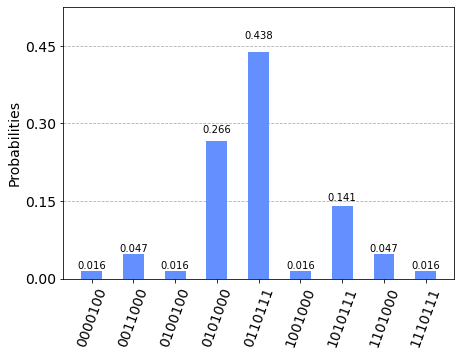

In [7]:
delta = 64
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ, simulator, shots=delta).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [ ]:
x = list(counts.keys())
x = [pi*int(i[::-1], 2)/(2 ** k) for i in x]
p = list(counts.values())
p = p.index(max(p))
theta = min(x[p], pi-x[p])
m_estimate = (2 ** n) * (theta ** 2)
m = 2 ** a.count('x')
print('Estimated Count:')
print(m_estimate)
print('Actual Count:')
print(m)

Estimated Count:
7.710628438351065
Actual Count:
8


Thus, we see that we get  very close estimate of the required count. The attentive reader will notice an extra $Z$ gate in the least significant qubit of the $k$ qubit register. The purpose of this gate is to correct for a simple phase error. Our implementation of the $G$ operator introduces a global phase of $\pi$ to the state, which normally is harmless as it is a global phase. However, we have to be more careful when using the controlled $G$ operator. The $Z$ gate is only applied to the least significant qubit because a phase of $\pi$ disappears when raised to even powers; so $G_j$ for $j \geq 1$ contribute no phases.

## References
1. Grover, L.K., 1997. Quantum mechanics helps in searching for a needle in a haystack. Physical review letters, 79(2), p.325.
2. Mermin, N. D. (2007). Quantum computer science: An introduction. Cambridge University Press.
3. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
4. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/